# Work Dairy

* 1219 read papers
    * VAE: framework & overall mathematical idea
    * beta-VAE: framework derivation & disentanglement metric
    * SCAN: disentantglement & hierarchical representation (primitive->concept->relationship)
        * every level implements a different version of VAE
* 1220 Implement Beta-VAE
* 1221 Analyze primitive experiments and write report
* 1222 Analyze the relations between given factors and latent representations z
    * train more epochs(500/1000/2000)
    * draw correlation curves between latent representations and given factors using better model
    * mathematical details of VAE
* 1223 train on more samples (train_set = 695810, test set = 4975)
* to-do:
    * implement evaluation of disentanglement metric
    * further about SCAN

## Implementing Beta-VAE

In trying to understand [SCAN](https://openreview.net/pdf?id=rkN2Il-RZ), firstly I learned about and implemented Beta-VAE(Variantional AutoEncoder). The main references are the original [paper](https://openreview.net/forum?id=Sy2fzU9gl), and some codes on Github, [VAE](https://github.com/crcrpar/chainer-VAE).

### Preparing Dataset

We use [2D Shapes](https://github.com/deepmind/dsprites-dataset) dataset to evaluate the model, under the guidance of dataset example.

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Image

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

# Load dataset
dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']

metadata = dataset_zip['metadata'][()]

# Define number of values per latents and functions to convert to indices
latents_sizes = metadata['latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
  samples = np.zeros((size, latents_sizes.size))
  for lat_i, lat_size in enumerate(latents_sizes):
    samples[:, lat_i] = np.random.randint(lat_size, size=size)

  return samples

# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']


### Setting Environment 

In [9]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import tensordataset
import os

os.system('mkdir results && mkdir save_models')

torch.manual_seed(1)
batch_size = 128
log_interval = 10
epochs = 100
VAE_beta = 4.0

# Sample latents randomly
latents_train = sample_latent(size=5000)
latents_test = sample_latent(size=1000)

# Select images
imgs_train = imgs[latent_to_index(latents_train)]
imgs_test = imgs[latent_to_index(latents_test)]

train_dataset = tensordataset.TensorDataset(torch.from_numpy(imgs_train).type(torch.FloatTensor))
test_dataset = tensordataset.TensorDataset(torch.from_numpy(imgs_test).type(torch.FloatTensor))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)




### Network Framework
Input: 4096 (ﬂattened 64x64x1).

Encoder: FC 1200, 1200. ReLU activation.

Latents: 10

Decoder: FC 1200, 1200, 1200, 4096. Tanh activation. Bernoulli.

In [41]:
class VAE(nn.Module):
    def __init__(self, imgSize=64*64):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(imgSize, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc21 = nn.Linear(1200, 10)
        self.fc22 = nn.Linear(1200, 10)
        self.fc3 = nn.Linear(10, 1200)
        self.fc4 = nn.Linear(1200, 1200)
        self.fc5 = nn.Linear(1200,1200)
        self.fc6 = nn.Linear(1200,imgSize)
        

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.imgSize = imgSize

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        #if self.training:
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
        #else:
        #return mu

    def decode(self, z):
        h3 = self.tanh(self.fc3(z))
        h4 = self.tanh(self.fc4(h3))
        h5 = self.tanh(self.fc5(h4))
        return self.sigmoid(self.fc6(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.imgSize))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, beta=VAE_beta, imgSize=4096):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, imgSize))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= batch_size * imgSize

    return BCE + beta * KLD

### Training the model

After training 100 epochs, the generator seems to know how to reconstruct position and rotation, but not so good at shapes, especially for hearts. I'm going to train more epochs for convergence.

The latest reconstruction figure is from epoch 260.

Train Epoch: 1 [0/5000 (0%)]	Loss: 0.005496
Train Epoch: 1 [1280/5000 (26%)]	Loss: 0.001258
Train Epoch: 1 [2560/5000 (51%)]	Loss: 0.000995
Train Epoch: 1 [3840/5000 (77%)]	Loss: 0.000798
====> Epoch: 1 Average loss: 0.0028
====> Test set loss: 0.0005


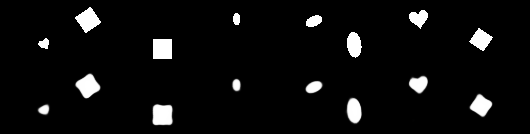

In [42]:
model = VAE()
optimizer = optim.Adagrad(model.parameters(), lr=1e-2)


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    for i, data in enumerate(test_loader):
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar, 0.5).data[0]
        if i == 0:
          n = min(data.size(0), 8)
          comparison = torch.cat([data[:n].resize(n,1,64,64),
                                  recon_batch.view(batch_size, 1, 64, 64)[:n]])
          save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, 1 + 1):
    train(epoch)
    test(epoch)
    sample = Variable(torch.randn(64, 10))
    sample = model.decode(sample).cpu()
    save_image(sample.data.view(64, 1, 64, 64),
               'results/sample_' + str(epoch) + '.png')
    
    torch.save(model.state_dict(), '{0}/model_epoch_{1}.pth'.format('save_models/', epoch))

#Image('reconstruction_99.png')

Image('reconstruction_260.png')

### Representations learnt by Beta-VAE

This part shows the results about the correlation between latent factors and representations learnt by model just like Figure6 in paper. We can sort the latent vectors by different dimensions to see what each latent $z_i$ represents.

According to the paper, we can visualize the images fixed on several latent values. The results of fixing POS_X, POS_Y, Scale, Rotation are as follows.

I'm going to draw correlation curves after training a better model.



In [43]:
eval_model = VAE()
#eval_model.load_state_dict(torch.load('model_epoch_2000.pth'))
eval_model.load_state_dict(torch.load('model_epoch_260.pth', map_location=lambda storage, loc: storage))

Variable containing:
 0.0046  0.0743  0.0050  0.1302  0.0058  0.6705  0.0027  0.0447  0.0663  0.1963
[torch.FloatTensor of size 1x10]



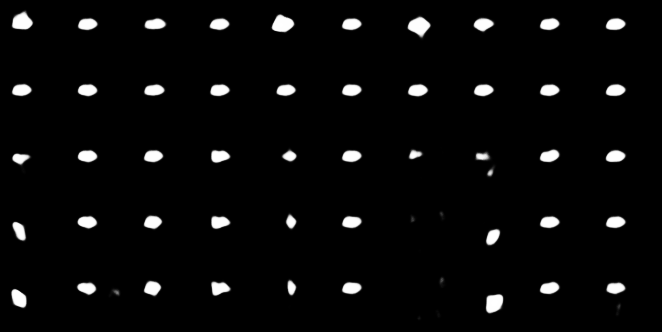

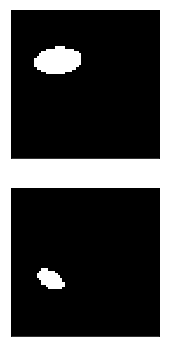

In [91]:
from IPython.display import Image
def fix_and_show(fix_dim=-2, fix_setting=0, latent_idx=6):
    ## Fix posX latent to left
    latents_sampled = sample_latent(size=64)
    latents_sampled[:, fix_dim] = fix_setting
    indices_sampled = latent_to_index(latents_sampled)
    imgs_sampled = imgs[indices_sampled]

    imgs_sampled = Variable(torch.from_numpy(imgs_sampled).type(torch.FloatTensor), volatile=True)

    mu, logvar = eval_model.encode(imgs_sampled.view(-1, 64*64))

    a = mu.data.numpy()
    a_arg = np.argsort(a[:, latent_idx+1])
    a = a[a_arg]
    z = eval_model.reparameterize(mu, logvar)

    samples = eval_model.decode(z)
    samples = torch.from_numpy(samples.data.numpy()[a_arg])
    save_image(samples.view(64, 1, 64, 64),'eval_samples.png')

#fix_and_show(3,0,6)

def fix_and_traverse():
    results = torch.FloatTensor(50,1,64,64).zero_()
    latent_sampled = sample_latent(size=2)
    indice_sampled = latent_to_index(latent_sampled)
    img_sampled = imgs[indice_sampled]
    show_images_grid(img_sampled,2)
    img_sampled = img_sampled[0]
    img_sampled = Variable(torch.from_numpy(img_sampled).type(torch.FloatTensor), volatile=True)
    mu, logvar = eval_model.encode(img_sampled.view(-1, 64*64))
    z = eval_model.reparameterize(mu, logvar)
    #print(logvar)
    origin_z = z.data.clone()
    for i,(fixed_dim, k) in enumerate(zip(range(10), range(40,50))):
        z = Variable(origin_z.clone())
        for mean in range(-2,3):
            #print(mean)
            #print(z)
            z_revise = eval_model.reparameterize(mu*mean, logvar)
            z[0,fixed_dim] = z_revise[0,fixed_dim]
            #print(z)
            sample = eval_model.decode(z)
            results[k] = sample.data.view(-1,64,64)
            k -= 10
    
    save_image(results,'traverse.png',nrow=10)
    print(logvar.exp())
            
        
fix_and_traverse()       
Image(filename='traverse.png')
#Image(filename='eval_samples.png')

Fixed on each latents factors, draw the changing curves for each dimension of z, we can get the following results.
For the model we use didn't train on enough data(only 5000samples), I'm going to observe more data and calculate the mean activation and use more samples to train the model and see results of relations.

However, we can still find some dimension of z keep stable while others have different kind of fluctuation under the influence of factors.

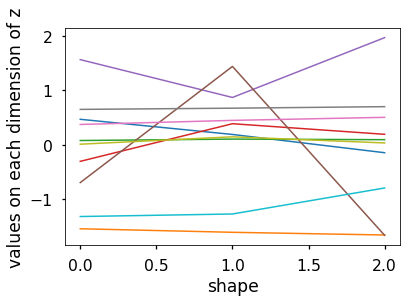

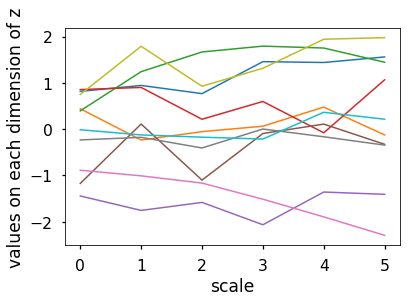

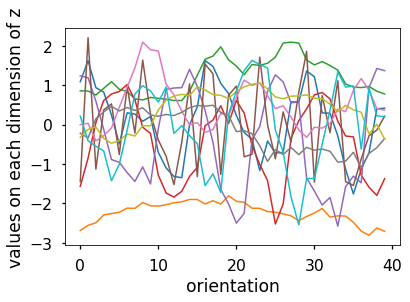

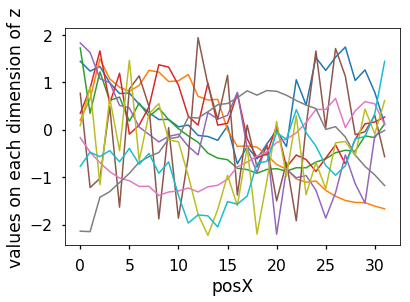

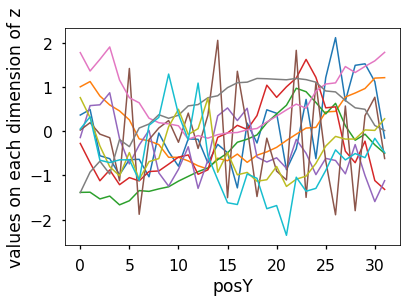

In [94]:
latents_names = ['color', 'shape', 'scale', 'orientation', 'posX', 'posY']
def curves(fixed_dim):
    lat_size = latents_sizes[fixed_dim]
    samples = np.zeros((lat_size, latents_sizes.size))
   

    for i, size in enumerate(latents_sizes):
        if i == fixed_dim:
            samples[:, i] = np.arange(0,lat_size,1)
        else: 
            random_x = np.random.randint(size)
            samples[:, i] = np.array([random_x]*lat_size)
    samples[:,1]=2
    indices_sampled = latent_to_index(samples)
    imgs_sampled = imgs[indices_sampled]
    #show_images_grid(imgs_sampled,lat_size)

    
    imgs_sampled = Variable(torch.from_numpy(imgs_sampled).type(torch.FloatTensor), volatile=True)
    mu, logvar = eval_model.encode(imgs_sampled.view(-1, 64*64))
    z = eval_model.reparameterize(mu, logvar)
    
    for i in range(10):
        plt.plot(z.data.numpy()[:,i])
    plt.ylabel('values on each dimension of z') 
    plt.xlabel(latents_names[fixed_dim]) 
    plt.show()
for i in range(1,latents_sizes.size):
    curves(i)
            
    

### Appendix

Some other tries for experiments.

#### EMNIST Dataset

To verify the effect of model, as first I tested its results on EMNIST Dataset.

Due to the size of dataset, downloading may take time, we can just see the results for the training process is similar with previous one.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    newdatasets.EMNIST('../data_emnist/', split='letters', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, drop_last=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    newdatasets.EMNIST('../data_emnist/', split='letters', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, drop_last=True, **kwargs)

model = VAE(28*28)

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    sample = Variable(torch.randn(64, 10))
    sample = model.decode(sample).cpu()
    save_image(sample.data.view(64, 1, 28, 28),
               'results_emnist/sample_' + str(epoch) + '.png')
    
    torch.save(model.state_dict(), '{0}/model_epoch_{1}.pth'.format('save_models_emnist/', epoch))

#### Results 

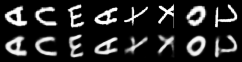

In [171]:
from IPython.display import Image

Image(filename='reconstruction_letters_92.png') 

#### Notes: evaluation method with disentanglement metric

Pseudocode of Equation(5)
```
for l:= 1 to L
    for y:= 1 to K
        for (v[i,y] = v[j,y]):= 1 to size_of_y
            for every sample pair VAE(v[i], v[j]) -> x[i],x[j]
                compute z_diff += |mu(x[i]),mu(x[j])|
z_diff /= L
classify z_diff
```
* 10 replices (different random seeds) -> disentangled representations
    * 3 times: factor change classification algorithom (different random seeds)